<h1>Sentiment Analysis and analysis of Bias in Wikipedia discussion forum</h1>


<h2>
Motivation
</h2>

<p>The goal of this project is to predict the sentiment of Wikipedia discussion comments and identify any sources of bias that may exist in the datasets, and to develop testable hypotheses about how these biases might impact the behavior of machine learning models trained on the data extracted from these datasets, when those models are used for research purposes or to power data-driven applications. </p>

<p>The corpus we use for the project is called the Wikipedia Talk corpus, and it consists of three datasets. Each dataset contains thousands of online discussion posts made by Wikipedia editors who were discussing how to write and edit Wikipedia articles. Crowdworkers labelled these posts for three kinds of hostile speech: “toxicity”, “aggression”, and “personal attacks”. Many posts in each dataset were labelled by multiple crowdworkers for each type of hostile speech, to improve accuracy. Google data scientists used these <a href='https://figshare.com/projects/Wikipedia_Talk/16731'>annotated datasets</a> to train machine learning models as part of a project called <a href='https://conversationai.github.io/'>Conversation AI</a>. The models have been used in a variety of software products and made freely accessible to anyone through the Perspective API.</p>

<p>For the purpose of this analysis, we will be focusing on personal attacks dataset </p>


<p>All data that we will be using from <a href='https://meta.wikimedia.org/wiki/Research:Detox'>Wikipedia Detox</a> project is available under free licenses on the <a href ='https://figshare.com/projects/Wikipedia_Talk/16731'>Wikipedia Talk Corpus on Figshare</a>, per the <a href='https://foundation.wikimedia.org/wiki/Open_access_policy'>open access policy</a>. There are currently two distinct types of data included:<p>
   <ol><li> A corpus of all 95 million user and article talk diffs made between 2001–2015 which can be scored by our personal attacks model.</li>
   <li> An annotated dataset of 1m crowd-sourced annotations that cover 100k talk page diffs (with 10 judgements per diff) for personal attacks, aggression, and toxicity.</li></ol>
<h4>These datasets can be downloaded from the below link</h4>

<a href='https://figshare.com/articles/dataset/Wikipedia_Talk_Labels_Personal_Attacks/4054689'>Wikipedia_Talk_Labels_Personal_Attacks</a>


<h3>Analyze the personal attacks datasets and  answer some of the following questions</h3>
<ul><li>Predict sentiments of personal attack comments using Naive Bayes</li>
    <li>Explore relationships between worker demographics and labeling behavior</li>
    <li>How consistent are labelling behaviors among workers with different demographic profiles? For example, are female-identified labelers more or less likely to label comments as aggressive than male-identified labelers?</li>
    <li>If the labelling behaviors are different, what are some possible causes and consequences of this difference?</li></ul>

<h2> Import packages</h2>

In [1]:
import pandas as pd
import urllib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer


import re                                  # library for regular expression operations
import string                              # for string operations

from nltk.corpus import stopwords          # module for stop words that come with NLTK
from nltk.stem import PorterStemmer        # module for stemming
from nltk.tokenize import word_tokenize  

# for displaying the plots inline
%matplotlib inline

[nltk_data] Downloading package stopwords to /home/lax/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<h2>Analysis of Personal Attacks dataset </h2>

<h4><em>Download annotated comments,annotations and demographic datasets for personal attacks directly from the urls and save them as .tsv files</em></h4>

In [2]:
# download annotated comments and annotations

personal_attacks_annotations_url = 'https://ndownloader.figshare.com/files/7554637' 
personal_attacks_annotated_comments_url = 'https://ndownloader.figshare.com/files/7554634' 
personal_attacks_worker_demographics_url = 'https://ndownloader.figshare.com/files/7640752'


def download_file(url, fname):
    urllib.request.urlretrieve(url, fname)

                
download_file(personal_attacks_annotations_url , 'personal_attacks_annotations.tsv')
download_file(personal_attacks_annotated_comments_url, 'personal_attacks_annotated_comments.tsv')
download_file(personal_attacks_worker_demographics_url, 'personal_attacks_worker_demographics.tsv')

<h4><em> Read all the .tsv files as tab seperated files for personal attacks and save them as python dataframes </em></h4>

In [3]:
personal_attacks_comments = pd.read_csv('personal_attacks_annotated_comments.tsv', sep = '\t', index_col = 0)
personal_attacks_demographics = pd.read_csv('personal_attacks_worker_demographics.tsv',  sep = '\t')
personal_attacks_annotations = pd.read_csv('personal_attacks_annotations.tsv',  sep = '\t');

<h3> Potential sources of bias in Personal Attacks dataset: </h3>

<p>Analyzing the demographic information about the Crowdflower workers available in the demographics dataset, we can say that these workers represent a very small proportion of population and their opinions and preferences are unlikely to reflect the opinions of the population as a whole. Even if the crowdworkers are perfectly representative of the wide population in their judgements, the raw data they are rating may be insufficient and thus suggest false correlations.How toxic a comment is perceived by annotators may depend on both the annotator and the topic</p>

<ul>
    <li>There are only about 2190 crowdsource workers.</li>
    <li>The gender distribution for the annotators is as follows - Male: 1349, Female: 840, and other: 1. </li>
</ul>    

<p>Let's understand the different columns in the <strong>demographics</strong> dataset</p>
<ul><li><strong>worker_id</strong>: Anonymized crowd-worker id.</li>
<li><strong>gender</strong>: The gender of the crowd-worker. Takes a value in {'male', 'female', and 'other'}.</li>
<li><strong>english_first_language</strong>: Does the crowd-worker describe English as their first language. Takes a value in {0, 1}.</li>
<li><strong>age_group</strong>: The age group of the crowd-worker. Takes on values in {'Under 18', '18-30', '30-45', '45-60', 'Over 60'}.</li>
<li><strong>education</strong>: The highest education level obtained by the crowd-worker. Takes on values in {'none', 'some', 'hs', 'bachelors', 'masters', 'doctorate', 'professional'}. Here 'none' means no schooling, some means 'some schooling', 'hs' means high school completion, and the remaining terms indicate completion of the corresponding degree type.</li></ul>

<h3>Observations and addtional sources of bias</h3>
<ul><li><strong>Features missing values: </strong> Dataframe.count() gives the count of records that have values populated for each column in the dataset. If the dataset has missing values for features for a large number of examples, then that could be an indicator that certain characteristics of the data set are under-represented. Here we observe that no values are missing for any of the features in comments dataset. For demographics dataset, we are missing 1.5% of age_group feature values, but as this percentage is relatively small, we can ignore it. But if the percentage is very high, we need to understand the implications of missing data and undersatnd why they are missing</li>
    
<p><li><strong>Omitted variable bias: </strong> The research paper highlights that machines are being trained purely on features extracted only from the comment text instead of including features based on the authors’ past behavior and the discussion context. This means that we may be omitting some features which could be directly correlated with the response variable. For example, people’s cultural backgrounds and personal sensibilities play a significant role in whether they perceive content as personal attack. So considering information beyond the text, such as demographic
information about the speaker, can improve the accuracy for personal attack detection. Having some background information about the user of a post may be very predictive. A user who is known to write hate speech messages may do so again. A user who is not known to write such messages is unlikely to do so in the future. We do not have this information available. Also, without taking the context into account, the models will be not trained to generalize to unseen examples.</li></p>

<h3>Demographics dataset</h3>

<strong>We do the following in the below chunk of code: </strong>
<ul> 
    <li>Get an idea of what the comments dataset looks like using the dataframe.head()</li>
    <li>Get the count of missing values in the dataset using dataframe.count(). We infer from the results that none of the values are missing for any of the features</li>
<ul>

In [4]:
personal_attacks_demographics.head()

,worker_id,gender,english_first_language,age_group,education
0,833,female,0,45-60,bachelors
1,1072,male,0,30-45,bachelors
2,872,male,0,18-30,hs
3,2116,male,0,30-45,professional
4,453,male,0,30-45,hs


<p>For demographics dataset, we are <strong>missing 1.5%</strong> of age_group feature values, but as this percentage is relatively small, we can ignore it. But if the percentage is very high, we need to understand the implications of missing data and understand why they are missing</p>

In [5]:
df1 = personal_attacks_demographics
total = df1.isnull().sum().sort_values(ascending=False)
percent = (df1.isnull().sum()/df1.isnull().count()).sort_values(ascending=False)
missing_data_df1 = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data_df1[missing_data_df1['Total'] > 0]

,Total,Percent
age_group,35,0.015982


<h3>Comments dataset</h3>

<p> Lets understand the different columns in the comments dataset</p>

<ul><li><strong>rev_id: </strong> MediaWiki revision id of the edit that added the comment to a talk page (i.e. discussion).</li>
<li><strong>comment: </strong> Comment text. Consists of the concatenation of content added during a revision/edit of a talk page. MediaWiki markup and HTML have been stripped out. To simplify tsv parsing, \n has been mapped to NEWLINE_TOKEN, \t has been mapped to TAB_TOKEN and " has been mapped to ".</li>
<li><strong>year: </strong> The year the comment was posted in.</li>
<li><strong>logged_in: </strong> Indicator for whether the user who made the comment was logged in. Takes on values in {0, 1}.</li>
<li><strong>ns: </strong>Namespace of the discussion page the comment was made in. Takes on values in {user, article}.</li>
<li><strong>sample: </strong> Indicates whether the comment came via random sampling of all comments, or whether it came from random sampling of the 5 comments around a block event for violating WP:npa or WP:HA. Takes on values in {random, blocked}.</li>
<li><strong>split: </strong> For model building in our paper we split comments into train, dev and test sets. Takes on values in {train, dev, test}.</li></ul>


<strong>We do the following in the below chunk of code: </strong>
<ul> 
    <li>Get an idea of what the comments dataset looks like using the dataframe.head()</li>
    <li>Get the count of missing values in the dataset using dataframe.count(). We infer from the results that none of the values are missing for any of the features</li>
<ul>

In [6]:
personal_attacks_comments.head()

,comment,year,logged_in,ns,sample,split
rev_id,,,,,,
37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,train
44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002,False,article,random,train
49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",2002,False,article,random,train
89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev
93890,This page will need disambiguation.,2002,True,article,random,train


<p>For demographics dataset, we are <strong>not missing </strong> values for any of the features</p>

In [7]:
df1 = personal_attacks_comments
total = df1.isnull().sum().sort_values(ascending=False)
percent = (df1.isnull().sum()/df1.isnull().count()).sort_values(ascending=False)
missing_data_df1 = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data_df1[missing_data_df1['Total'] > 0]

,Total,Percent


<strong>We do the following in the below chunk of code: </strong>
<ul> 
    <li>Get an idea of what the comments dataset looks like using the dataframe.head()</li>
    <li>Get the count of missing values in the dataset using dataframe.isnull().sum(). We infer from the results that none of the values are missing for any of the features</li>
<ul>

In [8]:
personal_attacks_annotations.head()

,rev_id,worker_id,quoting_attack,recipient_attack,third_party_attack,other_attack,attack
0,37675,1362,0.0,0.0,0.0,0.0,0.0
1,37675,2408,0.0,0.0,0.0,0.0,0.0
2,37675,1493,0.0,0.0,0.0,0.0,0.0
3,37675,1439,0.0,0.0,0.0,0.0,0.0
4,37675,170,0.0,0.0,0.0,0.0,0.0


<p>For annotations dataset, we are <strong>not missing </strong> values for any of the features</p>

In [9]:
df1 = personal_attacks_annotations
total = df1.isnull().sum().sort_values(ascending=False)
percent = (df1.isnull().sum()/df1.isnull().count()).sort_values(ascending=False)
missing_data_df1 = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data_df1[missing_data_df1['Total'] > 0]

,Total,Percent


<strong>The below code chunk does the following</strong>
<ul><li>Remove newline and tab tokens from personal_attacks_comments dataset</li>
    <li>Label a comment as an attack if the majority of annotators did so. Here we assume a classifier threshold of 0.5, that is when more than 50% of annotators quote a comment as attack, we consider it an attack</li>
    <li>Create a new column attack in personal_attacks_comments dataset and assign the value to the labels created in the above step</li>
    <li>Display the dataframe using dataframe.head() function</li>
</ul>

In [10]:
personal_attacks_comments['comment'] = personal_attacks_comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
personal_attacks_comments['comment'] = personal_attacks_comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

In [11]:
labels = personal_attacks_annotations.groupby('rev_id')['attack'].mean() > 0.5
personal_attacks_comments['attack'] = labels
personal_attacks_comments.head()

,comment,year,logged_in,ns,sample,split,attack
rev_id,,,,,,,
37675,`- This is not ``creative``. Those are the di...,2002,False,article,random,train,False
44816,` :: the term ``standard model`` is itself le...,2002,False,article,random,train,False
49851,"True or false, the situation as of March 200...",2002,False,article,random,train,False
89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev,False
93890,This page will need disambiguation.,2002,True,article,random,train,False


/home/lax/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


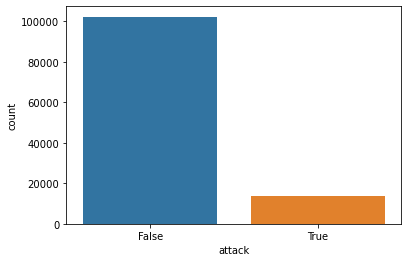

In [12]:
sns.countplot(personal_attacks_comments['attack'],label='Count');

In [13]:
personal_attacks_comments['length'] = personal_attacks_comments['comment'].apply(len)

<AxesSubplot:ylabel='Frequency'>

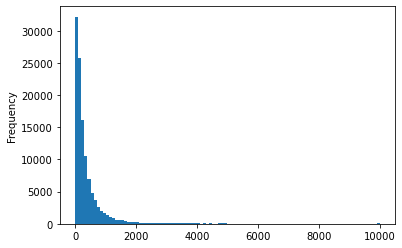

In [14]:
personal_attacks_comments['length'].plot(bins=100, kind='hist') 

In [15]:
comments = personal_attacks_comments['comment'].tolist()

In [16]:
comments_as_one_string=" ".join(comments)

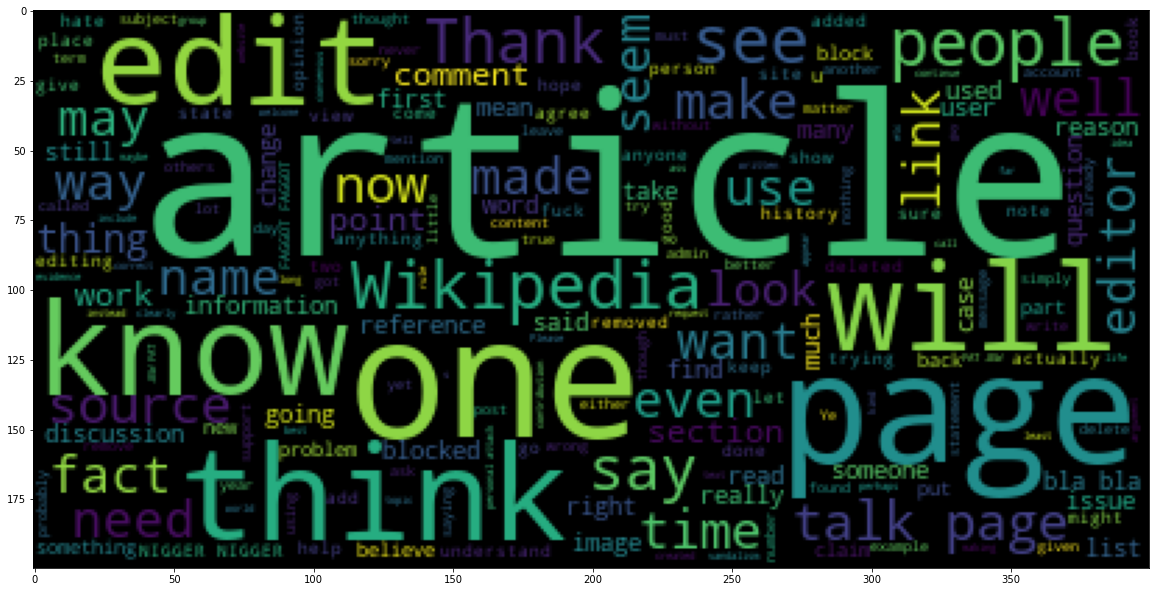

In [17]:
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(comments_as_one_string))

In [18]:
len(personal_attacks_comments)

115864

In [19]:
negative = personal_attacks_comments[personal_attacks_comments['attack']==True]
positive = personal_attacks_comments[personal_attacks_comments['attack']==False]

In [20]:
print(len(negative),len(positive))

13590 102274


In [21]:
comments_attacks_as_one_string=" ".join(negative['comment'].tolist())
comments_notattacks_as_one_string=" ".join(positive['comment'].tolist())

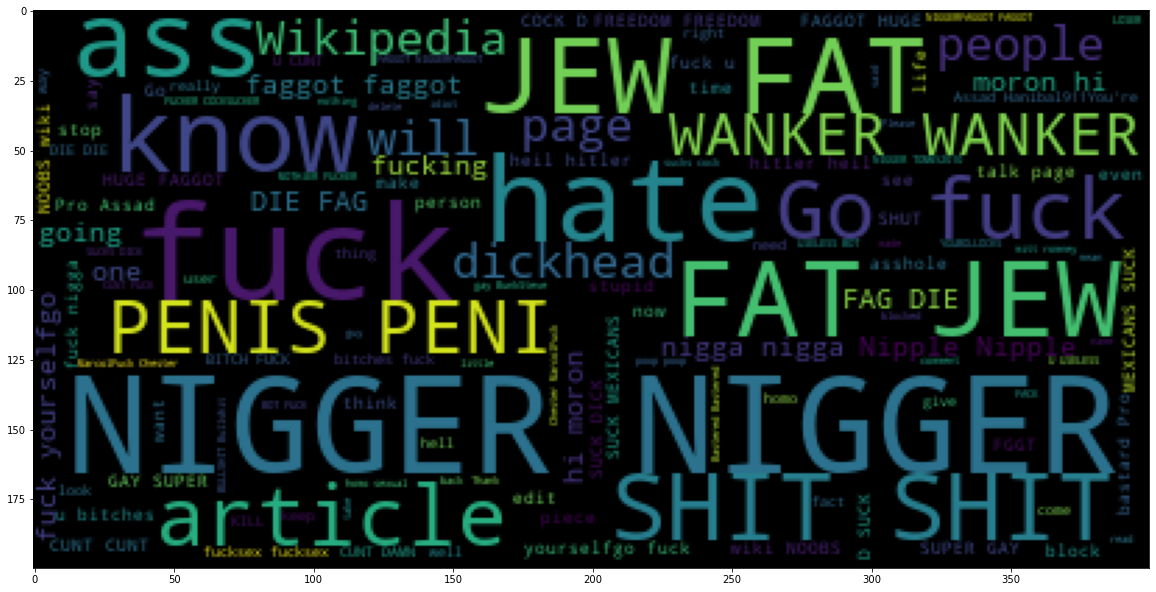

In [22]:
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(comments_attacks_as_one_string));

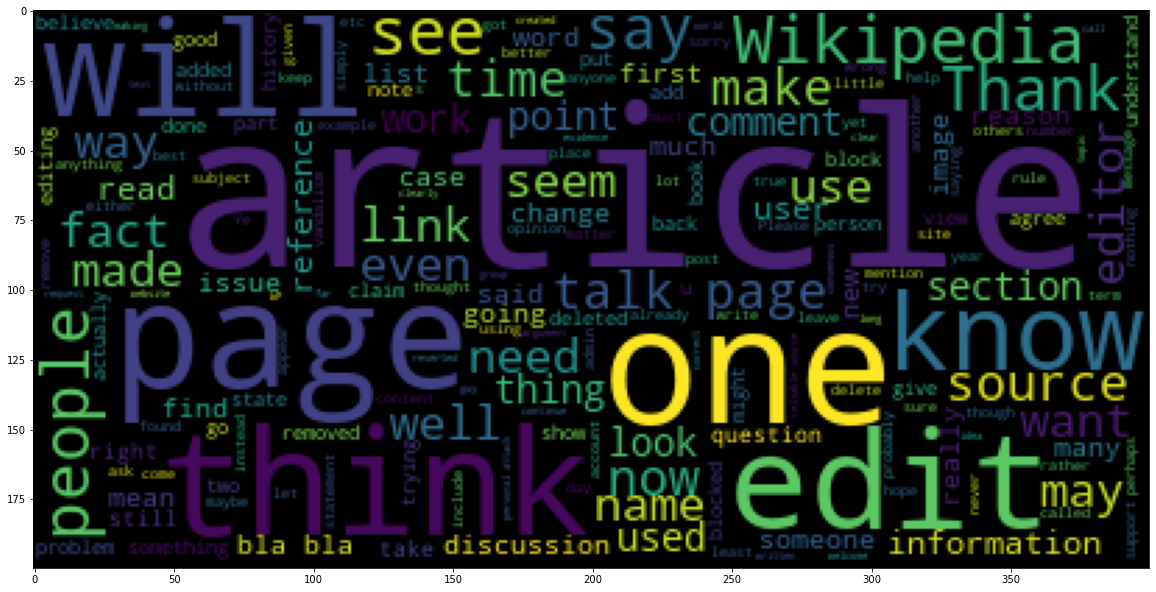

In [23]:
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(comments_notattacks_as_one_string));

In [24]:
import string
string.punctuation
stopwords_english = stopwords.words('english') 

In [25]:
personal_attacks_comments.head()

,comment,year,logged_in,ns,sample,split,attack,length
rev_id,,,,,,,,
37675,`- This is not ``creative``. Those are the di...,2002,False,article,random,train,False,2397
44816,` :: the term ``standard model`` is itself le...,2002,False,article,random,train,False,713
49851,"True or false, the situation as of March 200...",2002,False,article,random,train,False,329
89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev,False,429
93890,This page will need disambiguation.,2002,True,article,random,train,False,36


## Preprocess comments raw text for Sentiment analysis

Data preprocessing is one of the critical steps in any machine learning project. It includes cleaning and formatting the data before feeding into a machine learning algorithm. For NLP, the preprocessing steps are comprised of the following tasks:

Tokenizing the string
Lowercasing
Removing stop words and punctuation
Stemming

The below code does the following:
1. Convert the comment into string type
2. Remove hyperlinks, marks and styles - Since we have a Wiki dataset, we'd like to remove some substrings commonly used on the platform like the hashtag, marks, and hyperlinks. We'll use the re library to perform regular expression operations on our comment. We'll define our search pattern and use the sub() method to remove matches by substituting with an empty character (i.e. '')
3. To tokenize means to split the strings into individual words without blanks or tabs. The [tokenize](https://www.nltk.org/api/nltk.tokenize.html#module-nltk.tokenize.casual) module from NLTK allows us to do these easily. 
4. Remove stop words and punctuations. Stop words are words that don't add significant meaning to the text.
5. Use stemming to stem the words. Stemming is the process of converting a word to its most general form, or stem. This helps in reducing the size of our vocabulary. NLTK has different modules for stemming and we will be using the PorterStemmer module which uses the Porter Stemming Algorithm.

In [26]:
import re
import string
import numpy as np

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer


def process_comment(comment):
    """Process comment function.
    Input:
        comment: a string containing a comment
    Output:
        comments_clean: a list of words containing the processed comment

    """
    comment = str(comment) # to avoid an error
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    comment = re.sub(r'\$\w*', '', comment)
    # remove old style recomment text "RT"
    comment = re.sub(r'^RT[\s]+', '', comment)
    # remove hyperlinks
    comment = re.sub(r'https?:\/\/.*[\r\n]*', '', comment)
    # remove hashtags
    # only removing the hash # sign from the word
    comment = re.sub(r'#', '', comment)
    # tokenize comments
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    comment_tokens = tokenizer.tokenize(comment)

    comments_clean = []
    for word in comment_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            stem_word = stemmer.stem(word)  # stemming word
            comments_clean.append(stem_word)

    return comments_clean

# Frequency disctionary

<strong>build_freqs() helper function will build a dictionary where we can lookup how many times a word appears in the lists of positive or negative comments.  </strong>
<p>The outer for loop goes through each comment, and the inner for loop steps through each word in a comment.The freqs dictionary is the frequency dictionary that's being built.
The key is the tuple (word, label), such as ("happy",1) or ("happy",0). The value stored for each key is the count of how many times the word "happy" was associated with a positive label, or how many times "happy" was associated with a negative label.</p>

In [27]:
def build_freqs(comments, ys):
    """Build frequencies.
    Input:
        comments: a list of comments
        ys: an m x 1 array with the sentiment label of each comment
            (either 0 or 1)
    Output:
        freqs: a dictionary mapping each (word, sentiment) pair to its
        frequency
    """
    # Convert np array to list since zip needs an iterable.
    # The squeeze is necessary or the list ends up with one element.
    # Also note that this is just a NOP if ys is already a list.
    yslist = np.squeeze(ys).tolist()

    # Start with an empty dictionary and populate it by looping over all comments
    # and over all processed words in each comment.
    freqs = {}
    for y, comment in zip(yslist, comments):
        for word in process_comment(comment):
            pair = (word, y)
            #print("pair :",pair)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs

# Create train and test datasets

We split the data into train and test sets based on 'split' column in the original datasets. The datasets will have both positive and negative comments

In [28]:
# split the data into two pieces, one for training and one for testing (validation set) 
train_pos = positive.loc[positive['split'] == 'train', positive.columns == 'comment'].reset_index(drop=True)
train_neg = negative.loc[negative['split'] == 'train', negative.columns == 'comment'].reset_index(drop=True)

test_pos = positive.loc[positive['split'] == 'dev', positive.columns == 'comment'].reset_index(drop=True)
test_neg = negative.loc[negative['split'] == 'dev', negative.columns == 'comment'].reset_index(drop=True)

X_train = np.append(train_pos,train_neg) 
X_test = np.append(test_pos,test_neg) 

X_train = np.squeeze(np.array(X_train))
X_test = np.squeeze(np.array(X_test))

print(X_train.shape)
print(X_test.shape)

(69526,)
(23160,)


In [29]:
# combine positive and negative labels

y_train = np.append(np.ones((len(train_pos),1)), np.zeros((len(train_neg),1)))
y_test= np.append(np.ones((len(test_pos),1)), np.zeros((len(test_neg),1)))
print(y_train.shape)
print(y_test.shape)

(69526,)
(23160,)


# Preview of original comment and processed comment

In [30]:
# test the function below
print('This is an example of a positive comment: \n', X_train[0])
print('\nThis is an example of the processed version of the comment: \n', process_comment(X_train[0]))

This is an example of a positive comment: 
 `- This is not ``creative``.  Those are the dictionary definitions of the terms ``insurance`` and ``ensurance`` as properly applied to ``destruction``.  If you don't understand that, fine, legitimate criticism, I'll write up ``three man cell`` and ``bounty hunter`` and then it will be easy to understand why ``ensured`` and ``insured`` are different - and why both differ from ``assured``.  The sentence you quote is absolutely neutral.  You just aren't familiar with the underlying theory of strike-back (e.g. submarines as employed in nuclear warfare) guiding the insurance, nor likely the three man cell structure that kept the IRA from being broken by the British.  If that's my fault, fine, I can fix that to explain.  But ther'es nothing ``personal`` or ``creative`` about it.  I'm tired of arguing with you.  Re: the other article, ``multi-party`` turns up plenty, and there is more use of ``mutually`` than ``mutual``.  If I were to apply your sta

# Create frequency dictionary

In [31]:

freqs = build_freqs(X_train, y_train)

# check the output
print("type(freqs) = " + str(type(freqs)))
print("len(freqs) = " + str(len(freqs.keys())))
#print("freqs :",freqs)

type(freqs) = <class 'dict'>
len(freqs) = 115773


# Visualize certain identity words and negative words

In [32]:
# select some words to appear in the report. we will assume that each word is unique (i.e. no duplicates)
keys = ['black', 'muslim', 'feminist', 'woman', 'gay','deaf','blind','African','Asian','sexuality',
       'kill','hate','loser','destroy','attack','terror']

# list representing our table of word counts.
# each element consist of a sublist with this pattern: [<word>, <positive_count>, <negative_count>]
data = []

# loop through our selected words
for word in keys:
    
    # initialize positive and negative counts
    pos = 0
    neg = 0
    
    # retrieve number of positive counts
    if (word, 1) in freqs:
        pos = freqs[(word, 1)]
        
    # retrieve number of negative counts
    if (word, 0) in freqs:
        neg = freqs[(word, 0)]
        
    # append the word counts to the table
    data.append([word, pos, neg])
    
data

[['black', 765, 108],
 ['muslim', 572, 56],
 ['feminist', 50, 8],
 ['woman', 283, 32],
 ['gay', 432, 2559],
 ['deaf', 25, 2],
 ['blind', 130, 36],
 ['African', 0, 0],
 ['Asian', 0, 0],
 ['sexuality', 0, 0],
 ['kill', 740, 736],
 ['hate', 709, 3555],
 ['loser', 73, 645],
 ['destroy', 348, 76],
 ['attack', 2871, 376],
 ['terror', 240, 20]]

We can then use a scatter plot to inspect this table visually. Instead of plotting the raw counts, we will plot it in the logarithmic scale to take into account the wide discrepancies between the postive and negative raw counts 

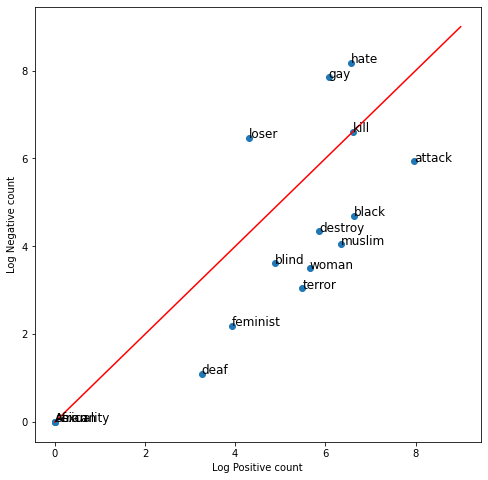

In [33]:
fig, ax = plt.subplots(figsize = (8, 8))

# convert positive raw counts to logarithmic scale. we add 1 to avoid log(0)
x = np.log([x[1] + 1 for x in data])  

# do the same for the negative counts
y = np.log([x[2] + 1 for x in data]) 

# Plot a dot for each pair of words
ax.scatter(x, y)  

# assign axis labels
plt.xlabel("Log Positive count")
plt.ylabel("Log Negative count")

# Add the word as the label at the same position as you added the points just before
for i in range(0, len(data)):
    ax.annotate(data[i][0], (x[i], y[i]), fontsize=12)

ax.plot([0, 9], [0, 9], color = 'red') # Plot the red line that divides the 2 areas.
plt.show()

We can see that words such as gay appear on the negative side.

# Fit Naive Bayes on comments dataset
Naive bayes is an algorithm that could be used for sentiment analysis. It takes a short time to train and also has a short prediction time.

In [34]:
def train_naive_bayes(freqs, X, y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        X: a list of tweets
        y: a list of labels correponding to the tweets (0,1)
    Output:
        logprior: the log prior.
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0

    # calculate V, the number of unique words in the vocabulary
    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)

    # calculate N_pos and N_neg
    N_pos = N_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1] > 0:

            # Increment the number of positive words by the count for this (word, label) pair
            N_pos += freqs.get(pair)

        # else, the label is negative
        else:

            # increment the number of negative words by the count for this (word,label) pair
            N_neg += freqs.get(pair)

    # Calculate D, the number of documents
    D = len(y)

    # Calculate D_pos, the number of positive documents (*hint: use sum(<np_array>))
    D_pos = np.sum(y == 1)

    # Calculate D_neg, the number of negative documents (*hint: compute using D and D_pos)
    D_neg = D - D_pos

    # Calculate logprior
    logprior = np.log(D_pos) - np.log(D_neg)

    # For each word in the vocabulary...
    
    for word in vocab:
        
        freq_pos = freq_neg = 0
        # get the positive and negative frequency of the word
        if (word,1.0) in freqs:
            freq_pos = freqs.get((word,1.0))
        
        if (word,0.0) in freqs:
            freq_neg = freqs.get((word,0.0))

        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos + 1)/(N_pos + V)
        p_w_neg = (freq_neg + 1)/(N_neg + V)

        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos/p_w_neg)

    ### END CODE HERE ###

    return logprior, loglikelihood

In [35]:
logprior, loglikelihood = train_naive_bayes(freqs, X_train, y_train)

In [36]:
def naive_bayes_predict(comment, logprior, loglikelihood):
    '''
    Input:
        comment: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Output:
        p: the sum of all the logliklihoods of each word in the comment (if found in the dictionary) + logprior (a number)

    '''
    # process the comment to get a list of words
    word_l = process_comment(comment)

    # initialize probability to zero
    p = 0

    # add the logprior
    p += logprior

    for word in word_l:

        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            # add the log likelihood of that word to the probability
            p += loglikelihood[word]


    return p

p > 0 is positive and p < 0 is negative comment. 

In [37]:
def test_naive_bayes(X_test, y_test, logprior, loglikelihood):
    """
    Input:
        X_test: A list of comments
        y_test: the corresponding labels for the list of comments
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    Output:
        accuracy: (# of comments classified correctly)/(total # of comments)
    """
    accuracy = 0  # return this properly

    y_hats = []
    for comment in X_test:
        # if the prediction is > 0
        if naive_bayes_predict(comment, logprior, loglikelihood) > 0:
            # the predicted class is 1
            y_hat_i = 1
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0

        # append the predicted class to the list y_hats
        y_hats.append(y_hat_i)
    
    # error is the average of the absolute values of the differences between y_hats and test_y
    error = np.mean(np.abs(np.array(y_hats) - np.squeeze(y_test)))

    # Accuracy is 1 minus the error
    accuracy = 1 - error

    return accuracy

In [38]:
print("Naive Bayes accuracy = %0.4f" %
      (test_naive_bayes(X_test, y_test, logprior, loglikelihood)))

Naive Bayes accuracy = 0.9311


# Analysis of Bias in Data 

<p>We call the function <strong>identityInComment</strong> by passing in the comments that are perceived as personal attacks and also the list of identity words representing targeted groups that appear in these comments</p>

In [39]:
def identityInComment(str_list,identity_list):
    
    count_wrd =0 
    count_comment = 0
    wrd_list = []
    for s in str_list:
        count_comment+=1
        #print("master str : ",s)
        for wrd in identity_list:
            if(wrd in s):
                wrd_list.append(wrd)
                count_wrd+=1
                
    return count_wrd,count_comment,list(set(wrd_list))

<strong>The below code chunk does the following</strong>
<ul><li>Get the comments from the dataframe where attack column is True using dataframe.query into the list 'str_list'</li>
    <li>Define the list that contains some identity words as 'identity_list'</li>
    <li>Define the list that contains some words pertaining to hatespeech as 'hatespeech_list'</li>
    <li>Call the function identityInComment by passing in the arguments str_list and identity_list and get the values for count of identity words that appeared in these many number of comments and also the actual identity words</li>
    <li>Call the function identityInComment by passing in the arguments str_list and hatespeech_list and get the values for count of hatespeech words that appeared in these many number of comments and also the actual hatespeech words</li>
</ul>

<p>We can infer from the below results that some of the common words associated with personal attack are <strong>'deaf', 'blind', 'muslim', 'gay', 'black', 'woman', 'sexuality', 'feminist','destroy', 'loser', 'kill', 'hate', 'attack'</strong></p>

In [40]:
str_list = personal_attacks_comments.query('attack')['comment']
identity_list = ['black', 'muslim', 'feminist', 'woman', 'gay','deaf','blind','African','Asian','sexuality']
hatespeech_list = ['kill','hate','loser','destroy','attack','terror']
print()
count_wrd,count_comment,lst = identityInComment(str_list,identity_list)  
print("Number of times identity words appeared in comments that are perceived as attacks ==>", count_wrd , " times identity words in" , count_comment, " comments ") 
print("Identity words that appeared in the list: ",lst)
print()
count_wrd_hate,count_comment_hate,lst = identityInComment(str_list,hatespeech_list) 
print("Number of times hate-speech words appeared in comments that are perceived as attacks ==>", count_wrd_hate , " times hateful words in" , count_comment_hate, " comments ") 
print("Hate-speech words that appeared in the list: ",lst)


Number of times identity words appeared in comments that are perceived as attacks ==> 717  times identity words in 13590  comments 
Identity words that appeared in the list:  ['woman', 'deaf', 'African', 'gay', 'feminist', 'muslim', 'Asian', 'blind', 'sexuality', 'black']

Number of times hate-speech words appeared in comments that are perceived as attacks ==> 1707  times hateful words in 13590  comments 
Hate-speech words that appeared in the list:  ['destroy', 'terror', 'kill', 'loser', 'hate', 'attack']


<li><strong>Implicit or Experimenter's bias: </strong>For training classifiers, we need to create a corpus that contains a sufficient number and variety of examples of personal attacks. In order to ensure representativeness and overall prevalence of personal attack comments, comments are randomly sampled from the full corpus as well as from the blocked dataset that contains comments made by users who were blocked for violating Wikipedia’s policy on personal attacks. But this could be linked to Experimenter's bias because here the experimenter assumes that the comments from blocked dataset are indeed attacks. But thinking deeply, the comments from blocked dataset could also contain biased data. Automation tools could have scored the comments in the blocked dataset and induced some sort bias into the data. Besides this, even if the comments are attacks, they need not be personal attacks. The overall prevalence of personal attacks in the subset of corpus sampled randomly will still be small in the sample data. This means Machine may not have adequate hate speech data to train on</li>

<p><li><strong>Selection bias: </strong>This type of bias occurs when a model itself influences the generation of data that is used to train it. Blocked dataset contains comments made by users who were blocked for violating Wikipedia’s policy on personal attacks, but some of these comments could have been wrongly scored by automation tools based on Machine's learning that has induced biases and are just false positives. The below counts indicate that not all comments from the blocked dataset would necessarily be attacks. The count says 65126 comments from the blocked dataset may not be attacks at all in the first place. </li></p>

<p><li><strong>Unintended bias </strong> It can be observed that the frequently targeted groups, represented by the identity words such as “black”, “muslim”, “feminist”, “woman”, “gay” etc, are over-represented in abusive and toxic comments. This implies the training data used to train machines exhibit the same trend. When the training data used to train machine learning models contain these comments, ML models adopt the biases that exist in these underlying distributions.These identity terms of targeted groups appear far more often in abusive comments. It is much rarer for these words to appear in a positive, affirming statements.</li></p>

<p><li><strong>False positives: </strong> Flagging identity terms as hate-speech results in False Positives.There is little agreement on what actually constitutes hate speech. Translating an abstract definition into a clearer and more concrete one can make annotation easier, but doing so comes with its own risks. Tools that rely on narrow definitions will miss some of the targeted speech, may be easier to evade, and may be more likely to disproportionately target one or more subtypes
of the targeted speech. The general rule that false negatives and false positives should be balanced. However, this
assumption ignores the particular stakes of decisions that affect a person’s human rights, liberty interests,
or access to benefits </li></p>


In [41]:
df1= personal_attacks_comments
print("# records from blocked dataset considered an attack: ",len(df1[np.logical_and(df1['sample'] == 'blocked',df1['attack'] == True)]))
print("# records from blocked dataset considered not an attack: ",len(df1[np.logical_and(df1['sample'] == 'blocked',df1['attack'] == False)]))

# records from blocked dataset considered an attack:  13246
# records from blocked dataset considered not an attack:  65126


In order to understand the distribution of crowdflower workers in demographic datasets, we plot the histogram of gender feature. It clearly shows that males are overrepresented than females and other group

Males crowdflower workers:  1349
Female crowdflower workers:  840
Other gender crowdflower workers:  1


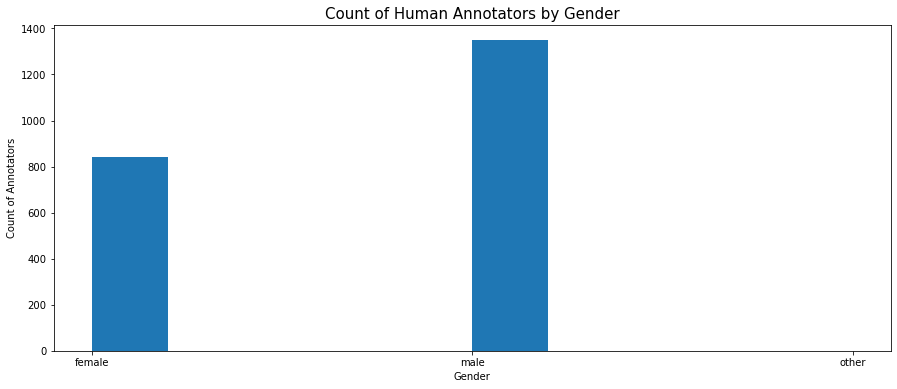

In [42]:
fig, ax = plt.subplots(figsize=(15, 6))
plt.hist(personal_attacks_demographics['gender'])
plt.xlabel("Gender")
plt.ylabel("Count of Annotators")
plt.title("Count of Human Annotators by Gender", size=15)
print("Males crowdflower workers: ",len(personal_attacks_demographics[personal_attacks_demographics['gender'] == "male"]))
print("Female crowdflower workers: ",len(personal_attacks_demographics[personal_attacks_demographics['gender'] == "female"]))
print("Other gender crowdflower workers: ",len(personal_attacks_demographics[personal_attacks_demographics['gender'] == "other"]))

In [43]:
fig.savefig('/home/lax/UWMSDS/gender_crowdflower.jpg')

<p> Lets understand the different columns in the <strong>annotations</strong> dataset</p>

<ul><li><strong>rev_id: </strong> MediaWiki revision id of the edit that added the comment to a talk page (i.e. discussion).</li>
<li><strong>worker_id: </strong> Anonymized crowd-worker id.</li>
<li><strong>quoting_attack: </strong> Indicator for whether the worker thought the comment is quoting or reporting a personal attack that originated in a different comment.</li>
<li><strong>recipient_attack: </strong> Indicator for whether the worker thought the comment contains a personal attack directed at the recipient of the comment.</li>
<li><strong>third_party_attack: </strong>Indicator for whether the worker thought the comment contains a personal attack directed at a third party.</li>
<li><strong>other_attack: </strong> Indicator for whether the worker thought the comment contains a personal attack but is not quoting attack, a recipient attack or third party attack.</li>
<li><strong>attack:  </strong> Indicator for whether the worker thought the comment contains any form of personal attack. The exact question we posed can be found . The annotation takes on value 0 if the worker selected the option "This is not an attack or harassment" and value 1 otherwise.</li></ul>


<strong>We do the following in the below chunk of code: </strong>
<ul> 
    <li>Get an idea of what the annotations dataset looks like using the dataframe.head()</li>
    <li>Get the count of missing values in the dataset using dataframe.count(). We infer from the results that none of the values are missing for any of the features</li>
<ul>

In [44]:
personal_attacks_annotations.head()

,rev_id,worker_id,quoting_attack,recipient_attack,third_party_attack,other_attack,attack
0,37675,1362,0.0,0.0,0.0,0.0,0.0
1,37675,2408,0.0,0.0,0.0,0.0,0.0
2,37675,1493,0.0,0.0,0.0,0.0,0.0
3,37675,1439,0.0,0.0,0.0,0.0,0.0
4,37675,170,0.0,0.0,0.0,0.0,0.0


In [45]:
personal_attacks_annotations.count()

rev_id                1365217
worker_id             1365217
quoting_attack        1365217
recipient_attack      1365217
third_party_attack    1365217
other_attack          1365217
attack                1365217
dtype: int64

<h3>Explore relationships between worker demographics and labeling behavior</h3>

<strong>  
Here, we get the number of crowdflower workers for each age group grouped by gender. For all the gender groups, the age group 18-30 has the highest number of annotators. Females have 395 annotators from age group 18-30. Males have 653 annotators from age group 18-30.</strong>

In [46]:
personal_attacks_demographics.groupby('gender')['age_group'].value_counts()

gender  age_group
female  18-30        395
        30-45        300
        45-60        114
        Over 60       11
        Under 18       9
male    18-30        653
        30-45        531
        45-60        104
        Under 18      28
        Over 60        9
other   18-30          1
Name: age_group, dtype: int64

<Figure size 720x576 with 0 Axes>

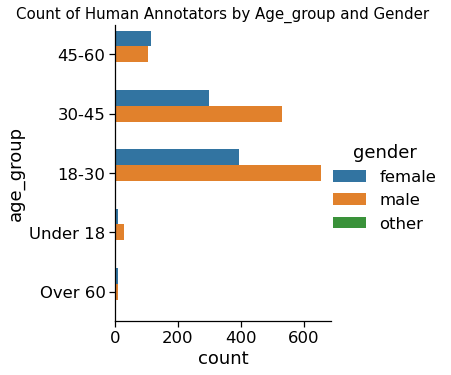

In [47]:
plt.figure(figsize=(10,8))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth":2})

sns_plot = sns.catplot(y="age_group", hue="gender", kind="count",
            data=personal_attacks_demographics)
plt.title("Count of Human Annotators by Age_group and Gender", size=15)
sns_plot.savefig('/home/lax/UWMSDS/genderbyAgegroup_attack.jpg');

<strong>For all the gender groups, the individuals with bachelors education constitute major chunk of annotators. Females have 363 annotators holding bachelors degree. Males have 498 annotators holding bachelors degree.</strong>

In [48]:
personal_attacks_demographics.groupby('gender')['education'].value_counts()

gender  education   
female  bachelors       363
        hs              240
        masters         148
        professional     63
        some             18
        doctorate         8
male    bachelors       498
        hs              391
        masters         237
        professional    180
        some             30
        doctorate        12
        none              1
other   bachelors         1
Name: education, dtype: int64

<Figure size 720x576 with 0 Axes>

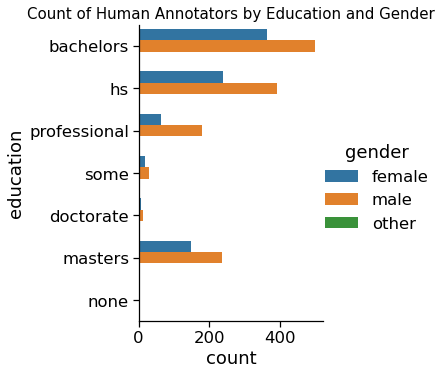

In [49]:
plt.figure(figsize=(10,8))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth":2})

sns_plot = sns.catplot(y="education", hue="gender", kind="count",
            data=personal_attacks_demographics)
plt.title("Count of Human Annotators by Education and Gender", size=15)
sns_plot.savefig('/home/lax/UWMSDS/genderbyEducation_attack.jpg');

<strong>For all the gender groups, the individuals that constitute major chunk of annotators have English not as first language. There are 637 female annotators and 1150 male annotators falling under this category.</strong>

In [50]:
personal_attacks_demographics.groupby('gender')['english_first_language'].value_counts()

gender  english_first_language
female  0                          637
        1                          203
male    0                         1150
        1                          199
other   0                            1
Name: english_first_language, dtype: int64

<Figure size 720x576 with 0 Axes>

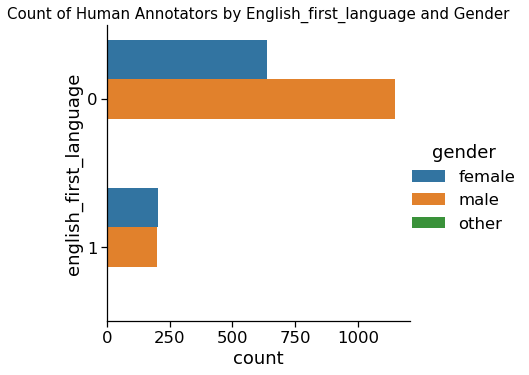

In [51]:
plt.figure(figsize=(10,8))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth":2})

sns_plot = sns.catplot(y="english_first_language", hue="gender", kind="count",
            data=personal_attacks_demographics)
plt.title("Count of Human Annotators by English_first_language and Gender", size=15)
sns_plot.savefig('/home/lax/UWMSDS/genderbyEngFirstLanguage_attack.jpg');

<h3>How consistent are labelling behaviors among workers with different demographic profiles? For example, are female-identified labelers more or less likely to label comments as personal attack than male-identified labelers?</h3>

<p><strong>A biased annotator population and group Attribution Bias: </strong> We see that females are more likely to call a comment an attack as compared to males. This is because females constitute only 38% and males constitute 61% of crowdflower workers. Some of the other gender groups such as transgenders constitute less than 1%. Females and other gender people are underrepresented in the data. This might potentially cause gender and group attribution bias where crowdflower workers belonging to a particular gender might consider comments targeting another gender not an attack. There is a tendency to stereotype individual members of a group to which crowdflower workers do not belong. At the same time, there is a preference for the members of the group that crowflower workers belong to. This means males who are overrepresented in the crowdflower group might not consider comments targeting women and other genders as an attack. This is one of the many reason why Females are more likely to label an attack as Personal attack as compared to males. Also, other gender groups are also poorly represented among the crowdflower workers, so we are not able to derive any useful information regarding the other group gender.<p>


<p>The below code chunk does the following</p>
<ul><li>An annotator is more likely to label comments as personal attack if more than 50% of the comments are labelled by the annotator as personal attacks</li>
    <li>Join the demographics with labels</li>
    <li>Display gender from the dataframe where attack is True using dataframe.query</li>
    <li>Display the dataframe using dataframe.head() function</li>
</ul>

<strong>Each annotator (identified by worked id) may have many comments to annotate. Each of the comments is identified by rev_id. If more than 50% of the comments are labelled by the annotator as personal attacks, then 'LabelCommentsAsAttack' will be True else False</strong>

In [52]:
labels = personal_attacks_annotations.groupby('worker_id')['attack'].mean() > 0.5
personal_attacks_demographics['LabelCommentsAsAttack'] = labels
personal_attacks_demographics.head()

,worker_id,gender,english_first_language,age_group,education,LabelCommentsAsAttack
0,833,female,0,45-60,bachelors,False
1,1072,male,0,30-45,bachelors,False
2,872,male,0,18-30,hs,False
3,2116,male,0,30-45,professional,False
4,453,male,0,30-45,hs,False


<p><strong>The below code chunk does the following</strong></p>
<ul><li>An annotator is more likely to label comment as personal attack if more than 50% of the comments are labelled by the annotator as personal attacks. We get all those annotators who meet this condition and get the gender distribution of these annotators</li>
    <li>We get the education distribution of annotators who are more likely to label a comment as attack</li>
    <li>We get the age_group distribution of annotators who are more likely to label a comment as attack</li>
</ul>

In [53]:
print(personal_attacks_demographics.query('LabelCommentsAsAttack')['gender'].value_counts())
print()
print(personal_attacks_demographics.query('LabelCommentsAsAttack')['education'].value_counts())
print()
print(personal_attacks_demographics.query('LabelCommentsAsAttack')['age_group'].value_counts())

male      27
female    25
Name: gender, dtype: int64

bachelors       17
hs              13
masters         12
professional     8
doctorate        2
Name: education, dtype: int64

30-45      24
18-30      23
45-60       4
Over 60     1
Name: age_group, dtype: int64


<strong>Male crowdflower workers who are likely to call a comment as personal attack constitute 2% and female annotators constitute 3%. This could be because of gender attribution bias. Also, most of the comments are targeted at females and other gender groups as compared to males.</strong>

In [54]:
print("Male crowdflower workers who are likely to call a comment as personal attack: ", (27/1349)*100 , " %")
print("Female crowdflower workers who are likely to call a comment as personal attack: ",  (25/840)*100 , " %")
print("Other gender crowdflower workers who are likely to call a comment as personal attack: ", 0, " %")

Male crowdflower workers who are likely to call a comment as personal attack:  2.001482579688658  %
Female crowdflower workers who are likely to call a comment as personal attack:  2.976190476190476  %
Other gender crowdflower workers who are likely to call a comment as personal attack:  0  %


<h3>If the labelling behaviors are different, what are some possible causes and consequences of this difference?</h3>

<ul><li>People’s cultural backgrounds and personal sensibilities play a significant role in whether they perceive content as personal attack. So considering information beyond the text, such as demographic
information about the speaker, can improve the accuracy for personal attack detection. Having some background information about the user of a post may be very predictive. A user who is known to write hate speech messages may do so again. A user who is not known to write such messages is unlikely to do so in the future. We do not have this information available. Also, without taking the context into account, the models will be not trained to generalize to unseen examples. This caused unintended bias so we want to have equal distribution of all gender types. Also, only a small proportion of annotators contributing this content and their opinions and preferences are unlikely to reflect the opinions of the population as a whole. We need to have more participation in human annotation. </li>
    
<p><li>There is little agreement on what actually constitutes hate speech. Translating an abstract definition into a clearer and more concrete one can make annotation easier, but doing so comes with its own risks. Tools that rely on narrow definitions will miss some of the targeted speech, may be easier to evade, and may be more likely to disproportionately target one or more subtypes of the targeted speech. The general rule that false negatives and false positives should be balanced. However, this assumption ignores the particular stakes of decisions that affect a person’s human rights, liberty interests, or access to benefits</li></p>